<img src="statics/iguide_logo.png" width=200 height=200 />

# Visualization of data in a THREDDS server on I-GUIDE Platform

This notebook demonstrates how to access, subset, and visualize AORC forcing data that is stored in HydroShare's Thredds catalog. This notebook is designed to access the data stored in this [hydroshare resource](https://www.hydroshare.org/resource/94a78b0e1f6f400785afe4da1d3fc7f0/).

In [1]:
import re
import dask
import numpy
import xarray
import requests
import xml.etree.ElementTree as ET

from dask.distributed import Client
Client()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 29.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38001,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 29.38 GiB
Comm: tcp://127.0.0.1:41507,Total threads: 2
Dashboard: http://127.0.0.1:43673/status,Memory: 7.35 GiB
Nanny: tcp://127.0.0.1:43853,


## Connect to the Thredds Server and Load Data

In [2]:
catalog_base_url = 'https://thredds.hydroshare.org/thredds/catalog'
dods_base_url = 'https://thredds.hydroshare.org/thredds/dodsC'
resource_id = '94a78b0e1f6f400785afe4da1d3fc7f0'

Read the files in the catalog via the catalog.xml document.
https://thredds.hydroshare.org/thredds/catalog/hydroshare/resources/94a78b0e1f6f400785afe4da1d3fc7f0/data/contents/20160101/catalog.xml

In [3]:
url = f'{catalog_base_url}/hydroshare/resources/{resource_id}/data/contents/20160101/catalog.xml'

Read the `catalog.xml` document and extract all `urlPath` attributes. We'll use the `urlPath` attribute to build the complete path to each file we want to access.

In [4]:
root = ET.fromstring(requests.get(url).text)
ns = '{http://www.unidata.ucar.edu/namespaces/thredds/InvCatalog/v1.0}'

In [5]:
# use xpath top select all "dataset" elements.
elems = root.findall(f'.//{ns}dataset')

In [6]:
# loop through results and extract the "urlPath" attribute values
paths = []
for elem in elems:
    atts = elem.attrib
    if 'urlPath' in atts.keys():
        paths.append(f"{dods_base_url}/{atts['urlPath']}")

In [7]:
# use regex to isolate only files that end with ".nc"
paths = list(filter(re.compile("^.*\.nc$").match, paths))

In [8]:
paths = [str(path) for path in paths]

Load the file paths using xarray

In [11]:
ds = xarray.open_mfdataset(paths, parallel=True,engine='netcdf4')

In [12]:
ds

<xarray.Dataset>
Dimensions:         (time: 24, reference_time: 1, x: 4608, y: 3840)
Coordinates:
  * time            (time) datetime64[ns] 2016-01-01 ... 2016-01-01T23:00:00
  * reference_time  (reference_time) datetime64[ns] 2016-01-01
  * x               (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y               (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Data variables:
    crs             (time) |S64 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    U2D             (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    V2D             (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    LWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    RAINRATE        (time, y, x) float32 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    T2D             (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    Q2D             (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    PSFC            (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    SWDOWN          (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
    LQFRAC          (time, y, x) float64 dask.array<chunksize=(1, 3840, 4608), meta=np.ndarray>
Attributes:
    model_output_valid_time:         2016-01-01_00:00:00
    model_initialization_time:       2016-01-01_00:00:00
    NWM_version_number:              v2.1
    model_configuration:             AORC
    model_output_type:               forcing
    model_total_valid_times:         744.0
    DODS.strlen:                     0
    DODS_EXTRA.Unlimited_Dimension:  time

## Plot 2d Grid of Data

Find the maximum RAINRATE in the first time slice. We'll use this to guess a region of cells that contain RAINRATE data.

In [13]:
ds_t0 = ds.RAINRATE.isel(time=0)
ds_max = ds_t0.where(ds_t0==ds_t0.max(), drop=True).squeeze()

In [14]:
# deterimine the x and y indices for the cell with maximum RAINRATE. 
# We'll use this to contruct a buffered range of cells to subset.
xidx = list(ds.x.values).index(ds_max.x.item())
yidx = list(ds.y.values).index(ds_max.y.item())


# sanity check. Searching ds at time=0 using xidx an yidx should give us the
# value from the previous cell
# ds.isel(time=0, x=xidx, y=yidx).RAINRATE.values.item() == ds_max.values.item()


In [15]:
# buffer the xidx and yidx that we found so that we have something more
# interesting to look at

xmin = xidx - 50
xmax = xidx + 50
ymin = yidx - 50
ymax = yidx + 50

Subset a region to plot

In [16]:
dat = ds.isel(x=range(xmin, xmax),
              y=range(ymin, ymax))

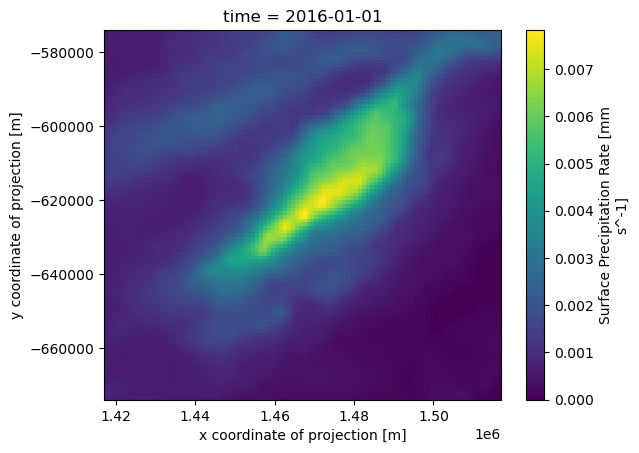

In [17]:
dat.isel(time=0).RAINRATE.plot()

Animate plot through time

In [18]:
# pyplot needed to plot the dataset, but animation only needed much further down.
from matplotlib import pyplot as plt, animation
%matplotlib inline

# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display


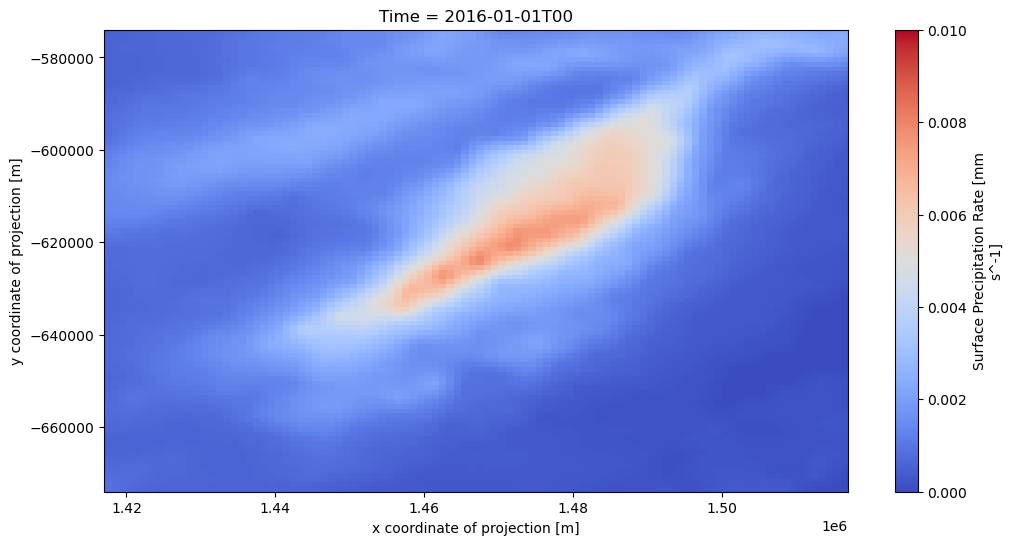

In [19]:
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot the initial frame. 
cax = dat.isel(time=0).RAINRATE.plot(
    add_colorbar=True,
    cmap='coolwarm',
    vmin=0, vmax=0.01,
    cbar_kwargs={
        'extend':'neither'
    }
)

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(dat.isel(time=frame).RAINRATE.values.flatten())
    ax.set_title("Time = " + str(dat.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             
    animate,         
    frames=len(dat.time),
    interval=200     
)

In [20]:
HTML(ani.to_jshtml())